# Lab 1: Text Corpora and Language Modelling

Welcome to the first lab assignment of INFOMNLP 2024.

This lab is meant to help you get familiar with some language data, and use this data to estimate simple models called N-gram language models.

First, you will use the **Penn Treebank**, which is a collection of newspaper articles from the newspaper
The Wall Street Journal. The idea is to examine the data and notice interesting properties. This will not take more than a few lines of code. The Penn Treebank may be the most widely used corpus in NLP.

Then you will use a corpus consisting of **TedX** talks. This you will use to estimate an **N-gram language model** for different orders of N, and use this for some tasks.

The dataset URLs are in the notebook and certain cells are responsible to download them.

# Rules
* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be the group number, e.g., `01.ipynb` or `31.ipynb`.

* The questions marked **Extra** or **Optional** are an additional challenge for those interested in going the extra mile. There are no points for them.

**Rules for implementation**

* You should **write your code and answers in this iPython Notebook**. (See http://ipython.org/notebook.html for reference material.) If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `## YOUR CODE HERE ##` comment.
    * Provide brief comments on what the code does at crucial points.
    * For theoretical questions, put your solution in the `█████ YOUR ANSWER HERE █████` cell and keep the header.

* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `#TEST...` or edit their code cells.
* Don't change the names of provided functions and variables or arguments of the functions.
* Leave the output of your code in the output cells.
* **Don't output unnecessary info** (e.g., printing variables for debugging purposes) or **add extra code cells** (e.g., for mounting your google drive). This clutters the notebook and slows down the grading.
* Test your code and **make sure we can run your notebook** in the colab environment.
* Don't forget to fill in the contribution information.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>  

# <font color="red">Contributions</font>

~~Delete this text and write instead of it your:~~
* ~~a list of group members names (NOT student IDs)~~
* ~~who contributed to which exercises (you don't need to be very detailed)~~

# General instructions

Before diving into the exercises, keep in mind that the variables defined previously can be reused in the subsequent cells. So there is no need to redefine the same variable in multiple sections, e.g., it is sufficient to read the file in a variable once and later reuse the value of the variable, instead of re-reading the file.   

If your code is too long and using several code cells instead of a single code cell. Rethink how to organize data in variables that you can easily access required info. Reading about [list comprehension](https://realpython.com/list-comprehension-python/#leverage-list-comprehensions) can be useful.

Your code will often be evaluated based on its behaviour. So, during the grading some code cells are executed. If code runtime is too long than expected, this will hinder grading.

<font color="red">**The cases similar to the above-mentioned ones, will be subject to penalty points.**</font>

<font color="red">**Pay attention to test units**</font> that are either provided as assert cases or as comments. Test units help you by giving you a hint about a correct answer. Note that **passing test units doesn't guarantee the full points** for an execise because test units are incomplete and the code might fail on other test units.

# Set up

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [1]:
! rm -rf data # remove if it was downloaded
! wget -nv -P data https://naturallogic.p   ro/_files_/download/mNLP/PTB/sec02-21.gold.tagged # download the file
! wget -nv -P data https://naturallogic.pro/_files_/download/mNLP/PTB/sec00.gold.tagged
! wget -nv -P data https://naturallogic.pro/_files_/download/mNLP/TED/ted-train.txt
! wget -nv -P data https://naturallogic.pro/_files_/download/mNLP/TED/ted-test.txt

'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import requests

urls = [
    "https://naturallogic.pro/_files_/download/mNLP/PTB/sec02-21.gold.tagged",
    "https://naturallogic.pro/_files_/download/mNLP/PTB/sec00.gold.tagged", 
    "https://naturallogic.pro/_files_/download/mNLP/TED/ted-train.txt",
    "https://naturallogic.pro/_files_/download/mNLP/TED/ted-test.txt"
]

# Loop through the URLs and download each file
for url in urls:
    # Get the file name from the URL
    file_name = url.split("/")[-1]
    
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open a file for writing
        with open(file_name, "wb") as file:
            # Write the content of the response to the file
            file.write(response.content)
        print(f"Downloaded {file_name} successfully.")
    else:
        print(f"Failed to download {file_name}. Status code: {response.status_code}")

Downloaded sec02-21.gold.tagged successfully.
Downloaded sec00.gold.tagged successfully.
Downloaded ted-train.txt successfully.
Downloaded ted-test.txt successfully.


# Golab variables

In [18]:
PTB_FILES = {'train': 'data/sec02-21.gold.tagged', 'dev': 'data/sec00.gold.tagged'}
TED_FILES = {'train': 'data/ted-train.txt', 'test': 'data/ted-test.txt'}

# 1. Penn treebank

## Ex 1.1 [25pt]

You are provided with a corpus containing tokens with their Part-of-Speech tags (POS-tags for short). The format is
**token|POS** (one sentence per line) and the file name is **sec02-21.gold.tagged**. This data is extracted from Sections 02-21 from the Penn Treebank: these sections are most commonly used for training statistical models like POS taggers and parsers.

Note the **distinction between token & word**. "Token" is a technical term and represents an occurrence of a word. Here, "word" covers both lexical words and other symbols (e.g., punctuations or numbers). Often "word" is called "token type". So, one can say that a token type can have different occurrences and each occurrence is a token.

**[Hint]** **Figure 8.2** in chapter 8 of Jurafsky and Martin (see [here](https://web.stanford.edu/~jurafsky/slp3/8.pdf#page=4)) holds a summary of POS-tags used in the Penn Treebank tagset together with their meaning and some examples.

**[Hint]** The Python library [collections](https://docs.python.org/3.7/library/collections.html) has an object called `Counter` which will come in handy for this exercise.

### (a) Corpus & vocab [5pt]

**Print** the corpus size (i.e. the number of **tokens**).  
**Print** the size of the **vocabulary** of the corpus. Estimate the vocabulary size both by **lowercasing** all the tokens as well as by leaving the tokens in their **original orthography**.  

What is the **advantage** of lowercasing all the tokens in your corpus?  
What is a notable **downside**?  
**Give examples** of the advantage and the downside.

In [29]:
## YOUR CODE HERE ##
# Use PTB_FILES golab var
# TEST: original orthography vocab size = ...10 (i.e., the last two digits of the vocab size are "10")

from collections import Counter


with open(PTB_FILES["train"], 'r') as file:
    data = file.read()
    data = data.split()
    data = [word.split('|')[0] for word in data]
    data2 = data
    #I want to lowercase all elements in data2
    data2 = [word.lower() for word in data2]
    data = Counter(data)
    data2 = Counter(data2)
    print(f'original orthography vocab size = {len(data)} (i.e., the last two digits of the vocab size are "{len(data) % 100}")')
    print(f"lowercase ortography vocab size = {len(data2)} (i.e., the last two digits of the vocab size are '{len(data2) % 100}')")




    

original orthography vocab size = 44210 (i.e., the last two digits of the vocab size are "10")
lowercase ortography vocab size = 39384 (i.e., the last two digits of the vocab size are '84')


█████ YOUR ANSWER HERE █████

------
**For the rest of this exercise <font color="red">you should use the original orthography</font> of the data when answering the questions.**

------

### [Extra]

Plot a graph of word frequency versus rank of a word, in this corpus. Does this corpus obey **Zipf’s law**? For a better picture you might need to make the plot horizontally wide or consider an initial cutoff of ranked words.

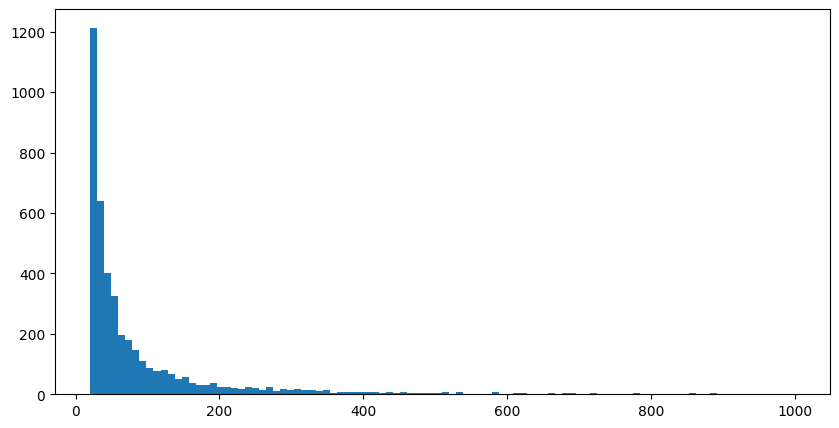

In [47]:
## YOUR CODE HERE ##
import matplotlib.pyplot as plt
import numpy as np




plt.figure(figsize=(10, 5))  # Adjust the width and height of the figure
plt.hist(data.values(), bins=100, range=(20,1000))
plt.show()


█████ YOUR ANSWER HERE █████

### (b) Tags & tokens [5pt]

**Print** a list of the **10 most commonly occurring POS tags** in the data. For each of these POS tags, additionally **print** the **3 most common token types** (i.e., words) that belong to that tag. Print raw counts for each printed tag and token type.

In [ ]:
## YOUR CODE HERE ##
# Use the following printing format and test your numbers for the DT pos tag:
# DT (82147):	the(40831); a(19151); The(6753)

### (c) Ambiguity [7pt]

A single token type (i.e. word) may occur with several POS tags. For example, *record* can be both a **noun** *(buy a record)* or a **verb** *(record a lecture)*. This makes POS tags extremely useful for **disambiguation**.

**Print** the percentage(!) of the **ambiguous** words in the vocabulary(!) (i.e. token types that have more than one POS tag?).  

Ambiguous words do not account for a great percentage of the vocabulary. Yet they are among the most commonly occurring words in the English language.  
**Print** the percentage of the dataset that is ambiguous (i.e., counting tokens of ambiguous token types/words wrt data size).  
(Don't round percentages when printing)

**Print** the **10 most frequently shared POS tag pairs** (i.e. POS tag pairs that share most words).  
**Print** the **4 most ambiguous** words (i.e. based on the number of POS tags it can get)

In [ ]:
## YOUR CODE HERE ##
# TEST: There are 1060 token types whose tokens get both ('VBD', 'VBN') tags
# TEST: in other tokens, a set of tokens with VBD and a set of tokens with VBN share 1060 elements

# print in the following way:
# Print ambiguous tokens and tag pairs as, where tags are ordered alphabetically:
# Top 10 confused tag pairs:
#	('VBD', 'VBN') share 1060 tokens
#   ...
#
# Top 4 ambiguous tokens:
# 	token: [POS_1, ..., POS_n]
#   ...

### (d) Explain [8pt]

**Take one** of the 4 most ambiguous tokens and for **each** of its possible POS tags **give** a sentence/phrase from the **training data** that shows the use of the token with its POS tag.  
For the other **three** tokens, **discuss ** the POS tag that is least likely in the training data for the corresponding token.      
Consult [Figure 8.2](https://web.stanford.edu/~jurafsky/slp3/8.pdf#page=4) for the interpretation of the POS tags. If you would like a more detailed explanation of the POS tags, consult [this technical report](http://www.cs.cmu.edu/afs/cs/Web/People/dgovinda/pdf/semantics/tagguide.pdf). Of course, you don't need to read it entirely, just use it to search for certain POS tags in it.

█████ YOUR ANSWER HERE █████

## Ex 1.2 [7pt]

You are also provided with another file called **sec00.gold.tagged**.
Section 00 of the Penn Treebank is typically used as development data.

### (a) Unseen % [5pt]

**Print** the percentages of the **unseen development vocabulary** and **unseen development data** (i.e., token types and tokens that occur in the development data but not in the training data). Percentages should be calculated wrt the development vocabulary/data size and they shouldn't be rounded.

In [ ]:
## YOUR CODE HERE ##
# Use PTB_FILES global var
# TEST: Difference between the percentages is in the interval 11-14%

### (b) Unseen tok tag [2pt]

**Print** the top **five** POS tags that the most **unseen tokens** belong to.

In [ ]:
## YOUR CODE HERE ##
# Print in the following format:
# POS_tag (the_number_of_corresponding_unseen_tokens)

# 2. Language Models



The following questions presuppose J&M's [chapter 3 on n-gram language models](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

Models that assign **probabilities** to **sequences of words** are called **language
models** or **LMs**. The simplest model that assigns probabilities to sentences and sequences of words is the **N-gram** model.

Recall that an *N*-gram language model uses **conditional probabilities** of the form
    
$$P(w_k \mid w_{k-N+1} \dots w_{k-1})$$

to **approximate** the full **joint probability**

$$P(w_1 \dots w_n)$$

of a sequence of words $w_1 \dots w_n$.

The easiest way of obtaining estimates for the probabilities $P(w_k \mid w_{k-N+1} \dots w_{k-1})$ is to use the **maximum likelihood estimate** or **MLE**, a widely used statistical estimation method ([read more](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)). You count and normalize:

$$P_{MLE}(w_k \mid w_{k-N+1} \dots w_{k-1}) = \frac{C(w_{k-N+1} \dots w_{k-1} w_k)}{C(w_{k-N+1} \dots w_{k-1})}.$$

## Ex 2.1 [25pt]

In this exercise you will have to train $N$-gram language models with an optional smoothing.

#### Some help

The `collections` library has another useful data structure: the `defaultdict`. Some example uses (learn more [here](https://realpython.com/python-defaultdict/) if needed):

**[Datastructure hint]** If you store the smoothed language in a naive manner (that is, to store *all* the numbers separately) your datastructure will get huge! If $V$ is the vocabulary then the smoothed bigram model assigns probabilities to $|V|^2$ entries. If $|V|$ is around 80k, the naive way requires you to store more than 64 billion floats. Yet almost all of these are actually just $P(w_n|w_{n-1}) = \frac{k}{N + k|V|}$, with $k$ the value with which you smooth and $N=C(w_{n-1})$. Think about how you use this fact to make your model work in practice.

In [ ]:
from collections import defaultdict

d = defaultdict(float)
d["new key"]

Compare that to an ordinary dictionary:

In [ ]:
# d = dict()
# d["new key"]
# Throws an KeyError: 'new key'

Other datatypes as `default_factory`:

In [ ]:
d = defaultdict(int)
print(d)
print(d["new key"])
print(d)

In [ ]:
d = defaultdict(list)
print(d)
print(d["new key"])
print(d)

Note how the defaultdict is modified after getting a value of a non-existing key. If you want to avoid modifying the defaultdict when getting a value for a non-existing key, do the following:

In [ ]:
d = defaultdict(list)
print(d)
print(d.get("new key", d.default_factory()))
print(d)

Converting an already existing `dict`:

In [ ]:
d1 = {k: "value" for k in range(1, 11)}
d = defaultdict(float, d1) # convert it to a defaultdict
print(d[5])
print(d[100])

This doesn't work:

In [ ]:
# d = defaultdict(10)
# Throws a TypeError: first argument must be callable or None

Use a `lambda` to make the number `10` `callable`":

In [ ]:
d = defaultdict(lambda: 10)
print(d)
print(d["new key"])
print(d)

In [ ]:
d = defaultdict(lambda: defaultdict(float))
print(d)
print(d["new key"])
print(d)

Note that in some cases the behaviour of lambda functions might be counterintuitive. One of such cases is the closure: [link1](https://realpython.com/python-lambda/#closure), [link2](https://stackoverflow.com/questions/2295290/what-do-lambda-function-closures-capture).

In [ ]:
# making a shortcut for the read-only get for defaultdict that supports several keys
# i.e. defget(d, [k1, k2]) will return the value of d[k1][k2] without altering d
def defget(d, keys):
    for k in keys:
        d = d.get(k, d.default_factory() if isinstance(d, defaultdict) else None) #PATCH
    return d

# testing if it works as intended
d = defaultdict(lambda: defaultdict(int))
d[1][1] = 2
d[2][1] = 3
print(d)
print(defget(d, [1, 1]))
print(defget(d, [3]))
print(defget(d, [3, 1]))
print(d)

Clever use of a `defaultdict` can be the solution to the problem of data-storing in a smoothing $N$-gram pointed out above:
    
    d = bigram_frequencies[history] = {w1: 120, w2: 340, w3: 7 ...}
    N = sum(d.values())
    # d_normalized = .... # normalize d with smoothing applied to elements already in the dictionary  
    d_smoothed = defaultdict(lambda: k/(N + kV), d_normalized) # add smoothing to 'unseen' words

The following function is given to assist you with reading the data from the file in a convenient format. Understand how the function works and figure out how to use it for training n-grams.

Note that the function uses padding symbols `<s>` and `</s>` to mark sentence boundaries. **When doing smoothing, include `</s>` in the vocabulary (and unigram models)**, otherwise after smoothing certain conditional probabilities will sum up higher than 1.  
🤔 It is a good practice to think of why this would be the case.  

In [ ]:
def read_data(fname, h=1, max_lines=np.inf):
    """
    Reads in the data from a file and returns a vocabulary as a set
    and the sentence-padded data as a list of list.

    :param fname: path to the file
    :param max_lines: the number of top lines to read (can be used for debugging)
    :param h: the length of n-gram history
    :returns: data as a list of lists and vocabulary as a set
    """
    data = []
    start = h * ["<s>"]
    end = ["</s>"]

    with open(fname, "r") as F:
        for k, line in enumerate(F):
            # an optional cut-off to read a part of the data
            if k > max_lines:
                break
            words = line.strip().split()
            # padding the sentence
            sent = start + words + end
            data.append(sent)
    return data

### train_ngram

[15pt] **Complete** the function `train_ngram` so that you can train a count-based $N$-gram language model on the data found in `data/ted-train.txt` and train this for $N=2,3$.

[10pt] **Extend** the function `train_ngram` so that it accepts a parameter `k` for optional add-$k$ smoothing (upgrade the same function, don't define new).

In [ ]:
def train_ngram(data, N=2, k=0):
    """
    Trains an n-gram language model with optional add-k smoothing
    and additionally returns the unigram model

    :param data: text-data as returned by the pre-defined function read_data
    :param N: (N>1) the order of the ngram e.g. N=2 gives a bigram
    :param k: optional add-k smoothing
    :returns: ngram and unigram
    """
    ngram = defaultdict(Counter) # ngram[history][word] = #(history,word)
    # for history of length >1, join tokens with a singel white space (see tests below)

    ## YOUR CODE HERE ##
    ## you can have auxiliary functions if needed, inside of outside this function's scope

    # the following line might be useful and its use is optional
    # unigram = defaultdict(float, Counter("SOME VAR HERE")) # default prob is 0.0

    return ngram, unigram

In [ ]:
# This shouldn't take more than 2min
Data1 = None ## YOUR CODE HERE ##
# use the global variable for the file path
# non-smoothed bigram
Bigram, Unigram = train_ngram(Data1, N=2, k=0)
# smoothed bigram
Bigram_sm, Unigram_sm = train_ngram(Data1, N=2, k=1)

In [ ]:
# Running this might take significant amount of memory
# Runtime shouldn't take more than 3min
Data2 = None ## YOUR CODE HERE ##
# non-smoothed trigram
Trigram, Unigram_ = train_ngram(Data2, N=3, k=0)
# smoothed trigram
Trigram_sm, Unigram_sm_ = train_ngram(Data2, N=3, k=1)

In [ ]:
#TEST 2.1
# Be aware that when getting a value of a non-existing key from defaultdict with d[key] method,
# the key gets inserted into the defaultdict. That's why tests use defget
assert defget(Bigram, ['all','people']) > 0
assert defget(Bigram, ['all','all']) == 0
assert defget(Bigram_sm, ['all','all']) == defget(Bigram_sm, ['all','asdasda'])
assert defget(Bigram_sm, ['all','asdasda']) > 0
assert defget(Trigram, ['<s> <s>','The']) > 0
assert defget(Trigram, ['<s> <s>','sun']) == 0
assert np.isclose(sum(Trigram['All the'].values()), 1) #almost 1, but not 1 because of float point rounding
assert defget(Trigram_sm, ['<s> <s>','sun']) > 0
assert defget(Unigram, ['</s>']) > 0
assert Unigram == Unigram_
assert Unigram_sm == Unigram_sm_

## Ex 2.2 [5pt]

You can use an *N*-gram language model to **generate text**. The higher the order *N* the better your model will be able to catch the long-range dependencies that occur in actual sentences and the better your chances are at generating sensible text. But beware: **sparsity** of language data will quickly cause your model to reproduce entire lines from your training data; in such cases, only one $w_k$ was observed for the histories $w_{k-N+1}\dots w_{k-1}$ in the entire training set.

### Some help

**[Hint]** You can use the method of [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) to generate a sample from a **categorical distribution**, $p_1\dots p_k$ such that $p_i \geq 0$ and $\sum_{i=1}^k p_i = 1$, as follows:

In [ ]:
import random

P = [0.2,0.5,0.2,0.1]

def sample(P):
    u = random.random() # random number between 0 and 1
    p = 0
    for i, p_i in enumerate(P):
        p += p_i
        if p > u:
            return i # the first i s.t. p1 + ... + pi > u

print(sample(P))

print(Counter([sample(P) for i in range(1000)])) # check to see if the law of large numbers is still true

Inverse transform sampling in the words of Jurafsky and Martin:

> Imagine all the words of the English language covering the probability space
between 0 and 1, each word covering an interval proportional to its frequency. We
choose a random value between 0 and 1 and print the word whose interval includes
this chosen value.

(J&M, [section 3.3](https://web.stanford.edu/~jurafsky/slp3/3.pdf#page=10))

### generate_sent

**Complete** the function `generate_sent`. It takes a language model `lm` and an order `N` and should generate a **natural language string(!)** (it shouldn't contain padding symbols and might not be a grammatical sentence) by **sampling** from the language model.

In [ ]:
def generate_sent(lm, N):
    """
    Generates sentence from a language model based on N-grams
    :param lm: language model based on N-grams
    :param N: denoting N-gram parameter
    :returns: a string of natural language tokens where tokens are separated with a space
    """

    ## YOUR CODE HERE ##
    ## you can have auxiliary functions if needed, inside of outside this function's scope

    raise NotImplementedError("Function not implemented yet")

In [ ]:
#TEST Ex2.2
random.seed(42) #uncommnet if you want to make the output non-deterministic

print("Bigram:\n")
print("\n".join([generate_sent(Bigram, 2) for _ in range(5)]))

print("\nTrigram:\n")
print("\n".join([generate_sent(Trigram, 3) for _ in range(5)]))

### [Extra]
No points for this

For how many of the histories $w_{k-N+1}\dots w_{k-1}$ is the number of continuations $w_n$ equal to **one**? Calculate the percentage of such cases for the different orders *N*.

And which history has the **most possible continuations**?

In [ ]:
## YOUR CODE HERE ##

YOUR ANSWER HERE

## Ex 2.3 Smoothing effect [5pt]

Let $V$ denote our vocabulary. Recall that for any $w \in V$ `bigram[w]` defines a conditional probability $p(v|w)$ over $v$ in $V$. In the case of an **unsmoothed bigram**, $p(v|w) = 0$ for most $v\in V$, whereas in the **smoothed bigram** smoothing took care that $p(v|w) > 0$ for *all* $v$.

The function `plot_bigram_dist(word, bigram, smoothbigram, k=30)` plots $p(v|word)$ for the `k` and words $v$. One bar shows the probabilities in `bigram` and one in `smoothbigram`.

1. Use `plot_bigram_dist` to plot the bigram distributions for two words, frequent $w_1$ and infrequent $w_2$, i.e., the distributions of $p(v|w_1)$ and $p(v|w_2)$. Adjust the cut-off `n` parameter for better visualization.

2. **Compare** the effect of `k=1` smoothing on the bigram distributions of the frequent $w_1$ and infrequent $w_2$ words. Give an informative insight instead of literally describing the plots.

3. Now plot the same distributions but with $k$ being much smaller than 1 (but greater than 0!). **Explain and contrast** how the value of $k$ affects the distributions of the frequent $w_1$ and infrequent $w_2$ words. Again, give an informative insight instead of literally describing the plots.

While providing the insights, try to be concise and right to the point.


**[Hint]** Remember that add-1 smoothing turns
$$P(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n})}{C(w_{n-1})}$$
into
$$P_{add-1}(w_n\mid w_{n-1}) = \frac{C(w_{n-1}w_{n}) + 1}{C(w_{n-1}) + |V|}.$$

In [ ]:
import pandas as pd
import seaborn as sns

def plot_bigram_dist(word, bigram, smoothbigram, n=30):
    d = bigram[word]
    #print(type(d))
    ds = smoothbigram[word]

    # sort the probabilities
    d_sort = sorted(d.items(), reverse=True, key=lambda t: t[1])[0:n]
    ds_sort = sorted(ds.items(), reverse=True, key=lambda t: t[1])[0:n]

    _, probs = zip(*d_sort)
    smooth_ws, smooth_probs = zip(*ds_sort)

    # make up for the fact that in the unsmoothed case non-0 probs is generally less than n long
    probs = probs + (0,) * (n-len(probs))

    w_data = pd.DataFrame({f"{word}": smooth_ws * 2,
                           f"P(w|{word})": probs + smooth_probs,
                           "smoothing": ["unsmoothed"]*n + ["smoothed"]*n})

    fig, ax = plt.subplots(figsize=(12,5))
    plt.xticks(rotation=90)
    g = sns.barplot(ax=ax, x=f"{word}", y=f"P(w|{word})", hue="smoothing",
                    data=w_data, palette="Blues_d")

In [ ]:
# Use these variables
Freq_word, Infreq_word = None, None

## YOUR CODE HERE ##

In [ ]:
# Use this K value and reuse Freq_word, Infreq_word
Small_k = 0.01

█████ YOUR ANSWER HERE █████

## Ex 2.4 Train sent. prob. [5pt]

**Recall** that if we have a sentence $w_1,\dots,w_n$ we can write

$$P(w_1\dots w_n) = P(w_1)P(w_2|w_1) \cdots P(w_n|w_1 \dots w_{n-1}) \approx P(w_1)P(w_2|w_1)\cdots P(w_n|w_{n-(N-1)}\dots w_{n-1})\prod_{i=1}^{n} P(w_i|w_{i-(N-1)}\dots w_{i-1})$$

where in the last step we make an $N$-gram approximation of the full conditionals.

For example, in the case of a bigram (N=2), the above expression reduces to

$$P(w_1 \dots w_n)\approx P(w_1)\prod_{i=2}^{n} P(w_i| w_{i-1}).$$

The following sentences are taken from the **training data**. Use your **unsmoothed unigram**, **bigram**, and **trigram** language model to estimate their **probabilities**:

    1. Every day was about creating something new .
    2. In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought together in a collision , producing a burst of pure energy .

In [ ]:
def sent_prob(sent, lm, N):
    """
    Calculates probability of sent based on the N-gram language mode lm
    :param sent: tokenized sentence string
    :param lm: N-gram language model
    :param N: N-gram size
    :returns: probabilitity number
    """
    ## YOUR CODE HERE ##

    return prob

In [ ]:
# Print all the abovemnetioned probabilities.
# The cell output should make it clear what number stands for which probability.
# Reuse the variables Unigram, Unigram_sm, Bigram, Bigram_sm, Trigram, and Trigram_sm.

Sents_from_train = (
    "Every day was about creating something new .",
    "In this machine , a beam of protons and anti-protons are accelerated to near the speed of light and brought together in a collision , producing a burst of pure energy ."
)

## YOUR CODE HERE ##

**Repeat** this with the **smoothed (add-1)** versions of the N-grams (in the same above code cell).   
**What** is the effect of smoothing on the probabilities and **how** the effect compare across the different $N$-grams models? Provide explanations for the effect and the comparison.

█████ YOUR ANSWER HERE █████

## Ex 2.5 Test sent. prob. [3pt]

The above sentences were taken from the training set, hence they will all have a probability greater than 0. The big challenge for our language model are of course with the sentences that contain unseen N-grams: if such an N-gram occurs our model immediately assigns the sentence probability zero.

The following sentences are taken from the **test set** available in the file **ted-test.txt**.  
**Print** the probabilities of the sentences based on the smoothed and unsmoothed language models.

    1. Because these robots are really safe .
    2. We have sheer nothingness on one side , and we have this vision of a reality that encompasses every conceivable world at the other extreme : the fullest possible reality , nothingness , the simplest possible reality .

In [ ]:
# Print all the abovemnetioned probabilities.
# The cell output should make it clear what number stands for which probability.
# Reuse the variables Unigram, Unigram_sm, Bigram, Bigram_sm, Trigram, and Trigram_sm.

Sents_from_test = (
    "Because these robots are really safe .",
    "We have sheer nothingness on one side , and we have this vision of a reality that encompasses every conceivable world at the other extreme : the fullest possible reality , nothingness , the simplest possible reality ."
)
### YOUR CODE HERE ###

**Contrast** the smoothed and unsmoothed probabilities and **explain** the drastic changes (if any) in terms of unseen tokens and sequences.

█████ YOUR ANSWER HERE █████

### [Extra]

**Optional** What percentage of the sentences in the test set get assigned probability 0 under your smoothed and unsmoothed language models?

In [ ]:
### ANSWER HERE ###

## Ex 2.6 Perplexity [5pt]

**Perplexity** is very frequently used **metric** for evaluating probabilistic models such as language models. The perplexity (sometimes called **PP** for short) of a language model on a sentence is the **inverse probability** of the sentence, **normalized** by the number of words:

$$PP(w_1 \dots w_n) = P(w_1\dots w_n)^{-\frac{1}{n}}.$$

Here we can again approximate $P(w_1 \dots w_n)$ with N-gram probabilities, as above.

Note: Calculation of perplexity has resemblance with the **geometric mean** $(x_1\cdots x_n)^{-\frac{1}{n}}$ of the numbers $x_1,\dots,x_n$. It is like the (regular) arithmetic mean, but with **products** instead of **sums**. The geometric mean is a more natural choice in the case of *PP* because behind $P(w_1\dots w_n)$ is a series of $n$ products ([more here](https://en.wikipedia.org/wiki/Geometric_mean)).



Compute the perplexity of the sentences in the training data (from exercise 2.1) based on the smoothed bigram language model. It is recommended to use `sent_prob` from Ex2.4.

What big difference between the **probabilities** of the sentences and the **perplexities** of the sentences do you notice?  
**Provide** a strong evidence (e.g., a concrete example or a plot) and **explain** the difference.

In [ ]:
# Feel free to reuse functions and variables form the previous exercises

### YOUR CODE HERE ###

█████ YOUR ANSWER HERE █████

# That's it!

Congratulations, you have made it to the end of the tutorial. Here we will recap the gist of this notebook.

**Make sure all your cells can be executed and all your answers are there. Then, read on if you're interested!**

-----

By now you should have a solid feeling for the problem of **sparsity in language data**; there's just never enough data. For the task of language modelling, we saw that sparsity is a serious challenge.

It would be great to be able to model $p(w_n|w_1 \dots w_{n-1})$ for unlimited $n$: the larger $n$ the better our language model should become at capturing the long-range dependencies between words that characterize actual human sentences, and the more probability our model will assign to such sentences as opposed to sentences that are word-soup. But in the N-gram approach, increasing $n$ will quickly kill all generalizing abilities of the model: the model will start to assign probabilities only to sentences it has seen in the training data.

So, where to go from here? Here are three directions that we could head in.

### Smoothing

We have seen one example of smoothing in this lab: add-k smoothing. This is an easy method, both conceptually and implementation-wise. But the results are not great, and the effects it has on the distributions can be extreme.

A much more sophisticated method of smoothing is **Kneser-Ney smoothing**. The method is described in detail in section 4.5 of J&M (3rd edition). This is one of the best-performing N-gram smoothing methods, and up to a few years ago, a popular implementation of it called [KenLM](https://kheafield.com/code/kenlm/) gave state-of-the-art results.

### From words to characters

In this lab we have considered language modeling as the task of predicting a **word** $w_n$ based on a history of **words** $w_1\cdots w_n$. What if instead we let our basic units of modelling be **characters**? The task then becomes to model $p(c_k\mid c_{k-N-1}\dots c_{k-1})$ where each $c_i$ is now an ASCII character instead of an entire word.

Suddenly sparsity of data is no longer a problem! The set of characters to use is tiny (< 100) compared to even a small-sized vocabulary as today. Have a look at this very illustrative notebook written by Yoav Golberg to see such a method in action: [The unreasonable effectiveness of Character-level Language Models](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139).

(So what is the downside?)


### Neural language models

The above notebook was actually written as a response to this blog post by Andrej Karpathy: [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Go ahead and read it if you haven't already: it is a superb introduction to the topic of Recurrent Neural Networks.

Neural language models solve the problem of data sparsity in a different manner. Instead of estimating the probabilities $p(w_k\mid w_{k-N-1}\dots w_{k-1})$ by counting occurrences in the data, they use a neural network $f_{\theta}$ parametrized by parameters $\theta$ to predict this probability. The parameters $\theta$ are learned through optimization.

The simplest approach goes like this: each word in the history $w_{k-N-1}\dots w_{k-1}$ is embedded separately giving vectors $e_{k-N-1}\dots e_{k-1}$ and then concatenated into one long vector $[e_{k-N-1};\dots ;e_{k-1}]$. The network then uses this history vector to predict a probability distribution over words $w$ in the vocabulary $V$:

$$p(w \mid w_{k-N-1}\dots w_{k-1}) = f_{\theta}([e_{k-N-1};\dots;e_{k-1}]).$$

(In order to produce legitimate probabilities the final layer of such a network will be for example a $softmax$.)

This provides a solution to the sparsity problem by having the network let the individual embeddings of the words in the history interact through its non-linear transformation. We are letting the network figure out the smoothing itself!

RNNs are a clever extension of this idea, where a hidden state vector $h$ is re-used and updated at each step $k$ in order to store the information of the entire history up to step $k-1$. That is, an RNN actually does away with the N-order approximation; it tries to model the full conditional directly! That means that

$$p(w \mid w_1\dots w_{k-1}) \approx RNN_{\theta}([e_{k-1};h_{k-1}])$$

where the hidden state $h_{k-1}$ is a compression of the *entire history* $w_1\dots w_{k-1}$.

Another great place to learn about RNNs, their problems, and solutions to those, is on the blog of [Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

-----------
(And now, it's time to read the classic essay by Eugene Wigner that gave both of the posts their title: [The Unreasonable Effectiveness of Mathematics in the Natural Sciences](http://www.dartmouth.edu/~matc/MathDrama/reading/Wigner.html))

# Acknowledgments

Most of this lab was developed in collaboration with Joost Bastings and Dan Douwe.  
Later it was revised by a couple of people.  
The recent updates by Lasha Abzianidze make the notebook more streamlined and foolproof from the grading and the large course perspectives.